In [1]:
import sys
sys.path.append('../src')
from vsa import VSA
import numpy as np

vsa = VSA(dim=2048)

# Recreate HKM with 5 facts for a stable validation
np.random.seed(42)
concepts = [f'concept_{i}' for i in range(10)]
atomic_vectors = {concept: vsa.make_vector() for concept in concepts}

facts = []
for i in range(0, 10, 2):
    role = atomic_vectors[concepts[i]]
    filler = atomic_vectors[concepts[i+1]]
    bound = vsa.bind(role, filler)
    facts.append(bound)

M = vsa.bundle(facts)

In [2]:
def generate_projections(vector, k, sub_dimension):
    """Generates k random projection matrices and the projected vectors."""
    projection_data = []
    for _ in range(k):
        # The projection matrix must map from the original dimension to the sub-dimension
        proj_matrix = np.random.normal(0, 1/np.sqrt(sub_dimension), (sub_dimension, vsa.dim))
        projected_vector = np.dot(proj_matrix, vector)
        projection_data.append((proj_matrix, projected_vector))
    return projection_data

def get_consensus(role, expected_filler, projection_data, sub_dimension, threshold=0.1):
    """Checks for consensus across multiple projected subspaces. Lowered threshold to make the problem harder."""
    agreements = 0
    temp_vsa = VSA(dim=sub_dimension)
    for proj_matrix, proj_vector in projection_data:
        # Project the role and filler into the SAME subspace
        projected_role = np.dot(proj_matrix, role)
        projected_filler = np.dot(proj_matrix, expected_filler)
        
        # Now perform the unbinding in the lower-dimensional space
        retrieved = temp_vsa.unbind(projected_role, proj_vector)
        
        # Check coherence in the subspace
        coherence = temp_vsa.cosine_similarity(retrieved, projected_filler)
        if coherence > threshold:
            agreements += 1
    
    # Require a supermajority for consensus
    return (agreements / len(projection_data)) > 0.8

Running MPCV simulation with a harder spurious fact...
k=1, Error Rate=0.03
k=2, Error Rate=0.00
k=3, Error Rate=0.00
k=4, Error Rate=0.00
k=5, Error Rate=0.00
k=6, Error Rate=0.00
k=7, Error Rate=0.00
k=8, Error Rate=0.00
k=9, Error Rate=0.00
k=10, Error Rate=0.00
k=11, Error Rate=0.00
k=12, Error Rate=0.00
k=13, Error Rate=0.00
k=14, Error Rate=0.00
k=15, Error Rate=0.00
k=16, Error Rate=0.00
k=17, Error Rate=0.00
k=18, Error Rate=0.00
k=19, Error Rate=0.00
k=20, Error Rate=0.00
k=21, Error Rate=0.00
k=22, Error Rate=0.00
k=23, Error Rate=0.00
k=24, Error Rate=0.00
k=25, Error Rate=0.00
Simulation complete.


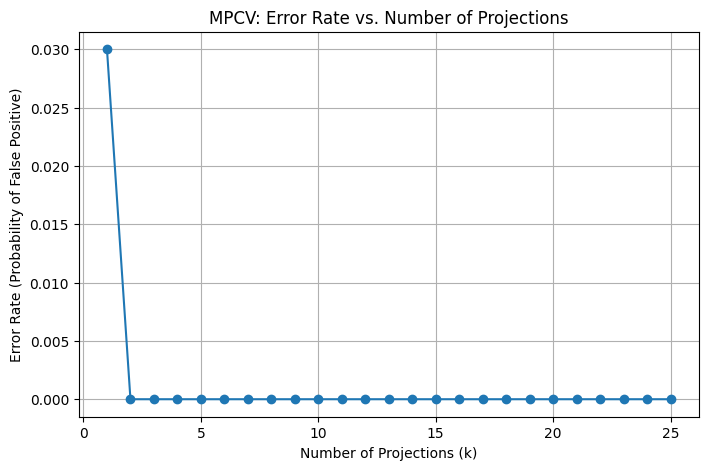

In [3]:
import matplotlib.pyplot as plt

# --- THE FIX: Create a 'harder' spurious fact ---
# It uses a noisy version of a REAL role, but an INCORRECT filler.
# This is more like a real-world hallucination (a near miss).
noise = np.random.normal(0, 0.3, vsa.dim) # Add significant noise
hard_spurious_role = atomic_vectors['concept_0'] + noise
hard_spurious_filler = atomic_vectors['concept_3'] # An incorrect filler

# Parameters
sub_dimension = 512
num_trials = 100
ks = range(1, 26)
error_rates = []

print('Running MPCV simulation with a harder spurious fact...')
for k in ks:
    errors = 0
    for _ in range(num_trials):
        projection_data = generate_projections(M, k, sub_dimension)
        # Use the new, harder spurious fact in the consensus check
        if get_consensus(hard_spurious_role, hard_spurious_filler, projection_data, sub_dimension):
            errors += 1
    error_rate = errors / num_trials
    error_rates.append(error_rate)
    print(f'k={k}, Error Rate={error_rate:.2f}') # Add progress indicator
print('Simulation complete.')

plt.figure(figsize=(8, 5))
plt.plot(ks, error_rates, marker='o', linestyle='-')
plt.xlabel('Number of Projections (k)')
plt.ylabel('Error Rate (Probability of False Positive)')
plt.title('MPCV: Error Rate vs. Number of Projections')
plt.grid(True)
plt.show()